In [1]:
#%% imports
import os, sys
import numpy as np
import pandas as pd
import copy

from utils_lib.etdata import ETData, tsv_to_npy
from utils_lib import utils
from utils_lib.data_loader import EMDataset, GazeDataLoader
from utils_lib.ETeval import run_infer

from model import gazeNET as gazeNET
import model as model_func

In [2]:
#%% init variables
dev = False
model_dir = 'model_final'
model_name = 'gazeNET_0004_00003750'

logdir =  os.path.join('logdir', model_dir)
fname_config = os.path.join(logdir, 'config.json')
configuration = utils.Config(fname_config)
config = configuration.params

config['split_seqs']=False
config['augment']=False
config['batch_size']=1

cuda = False
model_name = '%s.pth.tar'%model_name

In [3]:
#%% prepare model
num_classes = len(config['events'])
model = gazeNET(config, num_classes)
model_func.load(model, model_dir, config, model_name)
model.eval()

logdir/model_final/models/gazeNET_0004_00003750.pth.tar
Loading model: logdir/model_final/models/gazeNET_0004_00003750.pth.tar
done.


gazeNET(
  (conv_stack): Sequential(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(2, 11), stride=(1, 1), padding=(1, 5), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Dropout(p=0.25, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(2, 11), stride=(1, 1), padding=(1, 5), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Dropout(p=0.25, inplace=False)
    )
  )
  (rnn_stack): Sequential(
    (gru1): BatchRNN(
      (rnn): GRU(32, 64, bias=False, batch_first=True, bidirectional=True)
      (batch_norm_op): SequenceWise (
      BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (dropout_op): Dropout(p=0.25, inplace=False)
    )
    (gru2): BatchRNN(
      (rnn): GR

In [4]:
#%%testing
print ("Running testing")
kwargs = {
    'cuda': False,
    'use_tqdm': False,
    'eval': False,
}

etdata_gt = ETData()
etdata_pr = ETData()

root = 'etdata'
dataset = 'tobii'
fname = 'Kreuze_Random Recording1_short'
format = 'tsv'
fpath = '%s/%s/%s.%s'%(root, dataset, fname, format)
num_workers = 0

fdir, fname = os.path.split(os.path.splitext(fpath)[0])

#load data
if format == 'tsv':
   etdata = ETData()
   x, y, X_test = tsv_to_npy(fpath)
else:
    X_test = np.load(fpath)

_status = np.isnan(X_test['x']) | \
        np.isnan(X_test['y']) | \
        ~np.in1d(X_test['evt'], config['events'])
X_test['status'] = ~_status
test_dataset = EMDataset(config = config, gaze_data = [X_test])
n_samples = len(test_dataset)
test_loader = GazeDataLoader(test_dataset, batch_size=config['batch_size'],
                            num_workers=num_workers,
                            shuffle=False)
#predict
print ("Predicting %s" % fname)
_gt, _pr, pr_raw = run_infer(model, n_samples, test_loader, **kwargs)

# revert to kartesian
if format == 'tsv':
    X_test['x'] = x
    X_test['y'] = y

#glue back the predictions
_data_pr = copy.deepcopy(test_dataset.data)
for _d, _pred in zip(_data_pr, pr_raw):
    _d['evt'] = 0
    _d['evt'][1:] = np.argmax(_pred, axis=1)+1
_data_pr = pd.concat([pd.DataFrame(_d) for _d in _data_pr]).reset_index(drop=True)
_data = pd.DataFrame(X_test)
_data = _data.merge(_data_pr, on='t', suffixes=('', '_pred'), how='left')
_data['evt'] = _data['evt_pred'].replace({np.nan:0})

Running testing
Predicting Kreuze_Random Recording1_short
[FP], n_samples: 1, dur: 4.19


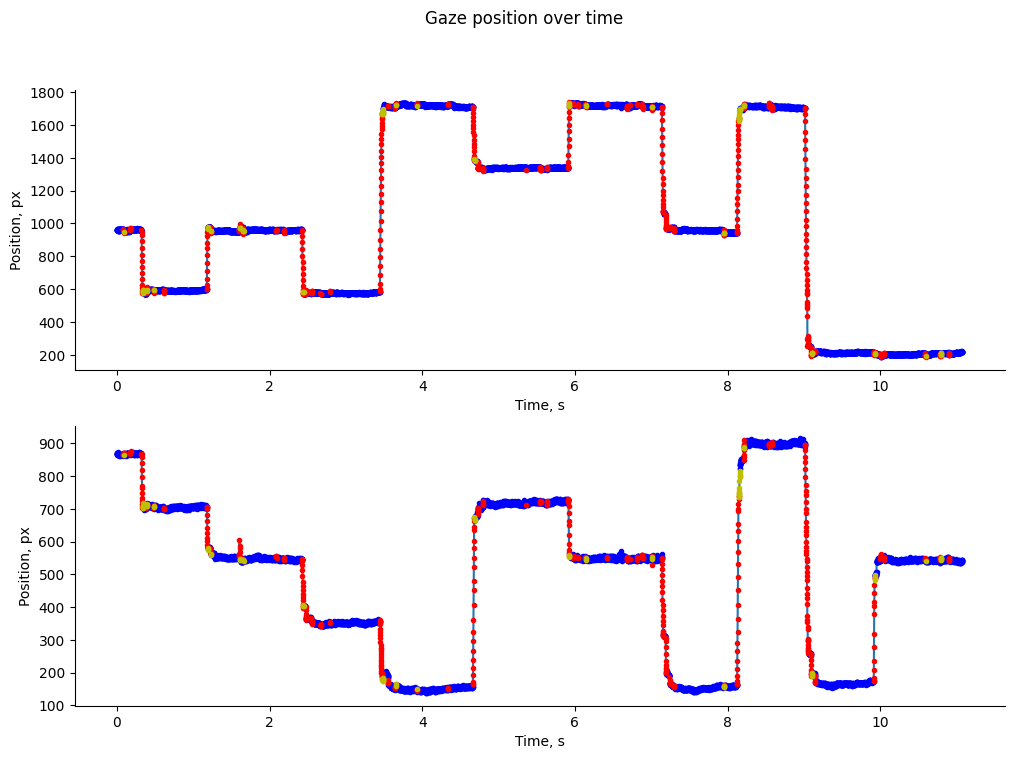

In [5]:
from utils_lib.etdata import ETData

etdata_pr.load(_data[['t', 'x', 'y', 'status', 'evt']].values, **{'source':'np_array'})

sdir = fdir.replace(dataset, '%s_gazeNet_copy'%dataset)
if not os.path.exists(sdir):
    os.mkdir(sdir)
spath = '%s/%s'%(sdir, fname)
etdata_pr.save(spath)
etdata_pr.plot_px(show=True, save=False, spath='%s'%spath)